<a href="https://colab.research.google.com/github/OculusMode/ILL/blob/main/experimental/random_subspaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
from numpy import random, linalg as LA
import matplotlib.pyplot as plt

In [2]:
TOTAL_VECTORS = 64
VECTOR_SIZE = 8
random_vectors = random.rand(TOTAL_VECTORS, VECTOR_SIZE)

In [3]:
def get_random_decomposition(random_vectors):
  # finding 8 random indices from 64 to choose random vectors
  random_indices = random.choice(TOTAL_VECTORS, size = VECTOR_SIZE)
  while True:
    random_chosen_vectors = random_vectors[random_indices]
    random_basis, _ = LA.qr(random_chosen_vectors)
    # making sure we got 8 basis
    if LA.matrix_rank(random_basis) == VECTOR_SIZE:
      break
  # number of subspaces to choose
  total_splits = random.randint(2, VECTOR_SIZE)
  # split points to split array
  split_points = np.random.choice(VECTOR_SIZE - 2, total_splits - 1, replace = False) + 1
  split_points.sort()
  return np.split(random_basis, split_points)


def projected_vector(basis, vector):
  # our basis vector here is row vector so (1, 10) => we want something like (10,1)
  return LA.norm(np.matmul(np.matmul(basis.T, basis), vector))

def projection(basis, vector):
  return LA.norm(projected_vector(basis, vector))

def lifting(initial_vector, basis_matrix, energy):
# projection of vector on subspace
  p1 = np.matmul(np.matmul(basis_matrix.T, basis_matrix), initial_vector)
  p2 = initial_vector - p1
  py = energy * p1 / (LA.norm(p1) + 0.001) + (1 - energy**2)**0.5 * p2 / (LA.norm(p2) + 0.001)
  py = py/LA.norm(py)
  return py

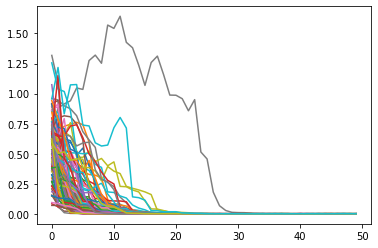

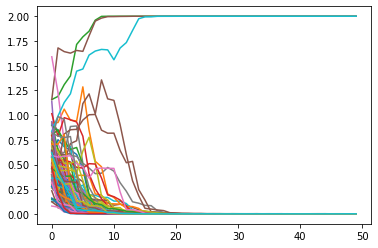

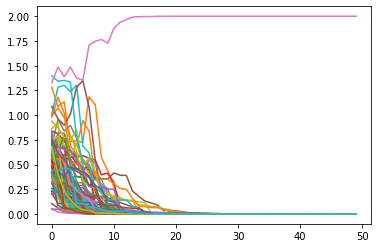

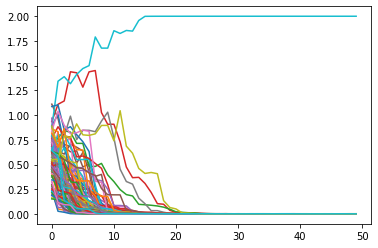

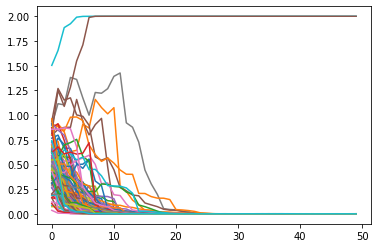

In [31]:
def run_test(epoch=100, no_decompositions=50):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  for i in range(epoch):
    decompositions = []
    for i in range(no_decompositions):
      decompositions.append(get_random_decomposition(random_vectors))

    signal = random.rand(VECTOR_SIZE)
    signal = signal/LA.norm(signal)

    random_vector = random.rand(VECTOR_SIZE)
    random_vector = random_vector/LA.norm(random_vector)
    # print(signal)
    # print('-'*50)
    x = np.arange(no_decompositions)
    error = []
    for d in decompositions:
      for subspace in d:
        energy = projection(subspace, signal)
        random_vector = lifting(random_vector, subspace, energy)
      error.append(LA.norm(random_vector - signal))
      # print(random_vector)
      # print(LA.norm(random_vector - signal), end=' ')
    # print()
    ax.plot(x, error)
    # plt.legend()
  plt.show()

for i in range(5):
  run_test()